## Testing the New AlphaEarth Foundations Satellite Embedding Dataset for Detailed Land Use Land Cover Classification
This script contain the classification process of Detailed Land Use Land Cover, while implementing SNI Classification scheme. This script use Google Earth Engine Python API, which were process entirely on cloud computing platform. The training data is created using visual interpretation, assisted with Indonesia Topographical Map
This script is organized as follows:
1. Library Import and platform preparation
2. Data Preparation
3. Parameter Optimization
4. Classification
5. Model Evaluation

**1. Importing the Necessary Library and credentials**

In [1]:
# import the library
import ee
import geemap
from geemap import ee_export_image_collection_to_drive
import numpy as np
import matplotlib as plt
import pandas as pd
import matplotlib.pyplot as plt
from gee_utils import get_sat_embedding
from gee_utils import extract_pixel_value
# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

**2. Data Preparation**
1. Define the area of interest (AOI)
2. Use *get_sat_embedding* function from *gee_utils.py* to filtered, and clip the dataset
3. Mosaic the images, since the area of interest is covered by two time periods (2023-2024 and 2024- 2025)

In [2]:
#example of Area of Interest 
aoi = ee.FeatureCollection('projects/ee-agilakbar/assets/AOI_Garsel_L9')
# Get embeddings for two different periods
image_2023 = get_sat_embedding(aoi, 2023, 2024)
image_2024 = get_sat_embedding(aoi, 2024, 2025)
#combine the two image
finalimage = ee.ImageCollection([image_2023, image_2024]).mosaic()
#add visualization parameter
vis_params = {'min': -0.3, 'max': 0.3, 'bands': ['A01', 'A16', 'A09']}

***2.1 Visualize the satellite embedding data***

In [3]:
# Adding Basemap
m = geemap.Map()
# set center of the map in the area of interest
m.centerObject(aoi, 10)
# adding the data
m.addLayer(finalimage, vis_params, 'Mosaic_embedd_2023-2024')
m

Map(center=[-7.500685301245826, 107.75130712444813], controls=(WidgetControl(options=['position', 'transparent…

***2.2 Defined the region of interest (ROI)***
<br>
1. The roi is created using visual interpretation using Landsat collection data, containing 21 Land Cover and Land
Use classes, based on Indonesia's official classification system (SNI)
2. Partitioned the original ROI into training and testing data using ***extract_pixel_value*** function. The partitioning process implement random partitioned with 60% allocated as training data and 40% as testing data


In [ ]:
# defining the training data
labeled_roi = ee.FeatureCollection('projects/ee-agilakbar/assets/LULC_Training_data_Garsel_project')
# partitioned the ROI into training and testing data, then extract the pixel values (sample regions)
train_samples, test_samples = extract_pixel_value(
    image=finalimage,
    roi=labeled_roi,
    class_property='LUCID',
    scale=10,
    split_ratio=0.5,
    tile_scale=16
)

**3. Parameter Optimization**
<br>
Since google earth engine did not have built-in parameter optimization, manual testing of the parameters is conducted. The SMILE Random Forest classifier is implemented, in which two primary parameters is tested, namely number of estimator (n_trees) and number of variable selected per split (var_split).

In [8]:
# Define your search grid
num_trees_list = ee.List.sequence(100, 400, 100)
var_split_list = ee.List.sequence(3, 16, 3)
#Create an empty list to collect results
results = []

# Loop over numberOfTrees
for n_tree in num_trees_list.getInfo():
    for var_split in var_split_list.getInfo():
        # Define and train classifier
        classifier = ee.Classifier.smileRandomForest(
            numberOfTrees=n_tree,
            variablesPerSplit=var_split
        ).train(
            features=train_samples,
            classProperty='LUCID',
            inputProperties=finalimage.bandNames()
        )

        # Apply classifier to test set and compute accuracy
        test_classified = test_samples.classify(classifier)
        error_matrix = test_classified.errorMatrix('LUCID', 'classification')
        try:
            accuracy = error_matrix.accuracy().getInfo()
        except:
            accuracy = 0  # fallback if something fails

        # Store result
        results.append({
            'numberOfTrees': n_tree,
            'variablesPerSplit': var_split,
            'accuracy': accuracy
        })

***3.1 Inspect the best parameters***

In [9]:
#convert the result into panda data frame
result_pd = pd.DataFrame(results)
#sort the accuracy to viewed the
df_sorted = result_pd.sort_values(by='accuracy', ascending=False)
best_result = df_sorted.iloc[0]

print("Best Hyperparameters:")
print(f"- Accuracy: {best_result['accuracy']:.3f}")
print(f"- numberOfTrees: {best_result['numberOfTrees']}")
print(f"- variablesPerSplit: {best_result['variablesPerSplit']}")

Best Hyperparameters:
- Accuracy: 0.873
- numberOfTrees: 400.0
- variablesPerSplit: 6.0


***3.2 Select the best parameters,  trained the classifier, and apply the model into the whole imagery***

In [ ]:
#get the best parameters
best_ntree = int(best_result['numberOfTrees'])
best_vsplit = int(best_result['variablesPerSplit'])
#apply the best parameters, and trained the model
final_classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=best_ntree,
    variablesPerSplit=best_vsplit
).train(
    features=train_samples,
    classProperty='LUCID',
    inputProperties=finalimage.bandNames()
)
#apply the trained model into the whole image
lulc_map = finalimage.classify(final_classifier)

**4. Visualize the result of the classification**

In [ ]:
legend_21 = [
    'Settlement Build-up', 'Non-settlement Build-up', 'Volcanic Rock and Sand', 'Lowland Forest',
    'Upland Forest', 'Mangrove Forest', 'Marine Sand', 'Herbs and Grassland', 'Production Forest',
    'Aquaculture', 'Dryland Agriculture', 'Natural Fallow Land', 'Man-made Fallow Land', 'Rubber and Other Hardwood Plantation',
    'Ocean Waters','Oil Palm Plantatation','Tea Plantation', 'Bushes and Shrubs', 'Rivers', 'Wetland Agriculture',
    'Natural/Semi Natural Freshwaterbody'
]

legend_colors = [
    '#FF0000', '#e97421', '#7b3531', '#2e8b57', '#228b22', '#7fffd4', '#fdd9b5',
    '#c1e1c1', '#9acd32', '#ccccff', '#f5ff00', '#b5a642', '#cc8899', '#32cd32',
    '#1f52dc', '#808000', '#98d97d', '#008080', '#87ceeb', '#afb325', '#0f3c5e'
]
Map = geemap.Map()

# Visualization
vis_params = {
    'min': 0,
    'max': len(legend_colors) - 1,
    'palette': legend_colors
}
Map.centerObject(aoi, 10)
Map.addLayer(lulc_map, vis_params, 'Classified Map')
# Add legend
Map.add_legend(title='Land Cover Legend', labels=legend_21, colors=legend_colors)
Map


Map(center=[-7.500685301245826, 107.75130712444813], controls=(WidgetControl(options=['position', 'transparent…

**5. Inspect the Model using feature importance analysis**

In [ ]:
# Get the raw importance dictionary
importance_dict = ee.Dictionary(final_classifier.explain().get('importance'))
# Sum of importance values
importance_sum = importance_dict.values().reduce(ee.Reducer.sum())
# Calculate relative importance (percentage)
relative_importance = importance_dict.map(
    lambda key, val: ee.Number(val).multiply(100).divide(importance_sum)
)
# Convert to FeatureCollection so it can be viewed/exported
importance_fc = ee.FeatureCollection([
    ee.Feature(None, relative_importance)
])

In [ ]:
# Convert dictionary to Python dict
importance_data = relative_importance.getInfo()
# Convert to pandas DataFrame
df_importance = pd.DataFrame(list(importance_data.items()), columns=['Band', 'Relative Importance (%)'])
# Sort by importance
df_importance = df_importance.sort_values(by='Relative Importance (%)', ascending=False)
print(df_importance)

   Band  Relative Importance (%)
36  A36                 1.811743
12  A12                 1.802641
56  A56                 1.783831
6   A06                 1.777946
22  A22                 1.771718
..  ...                      ...
19  A19                 1.394186
17  A17                 1.386244
62  A62                 1.353693
29  A29                 1.332755
49  A49                 1.261691

[64 rows x 2 columns]


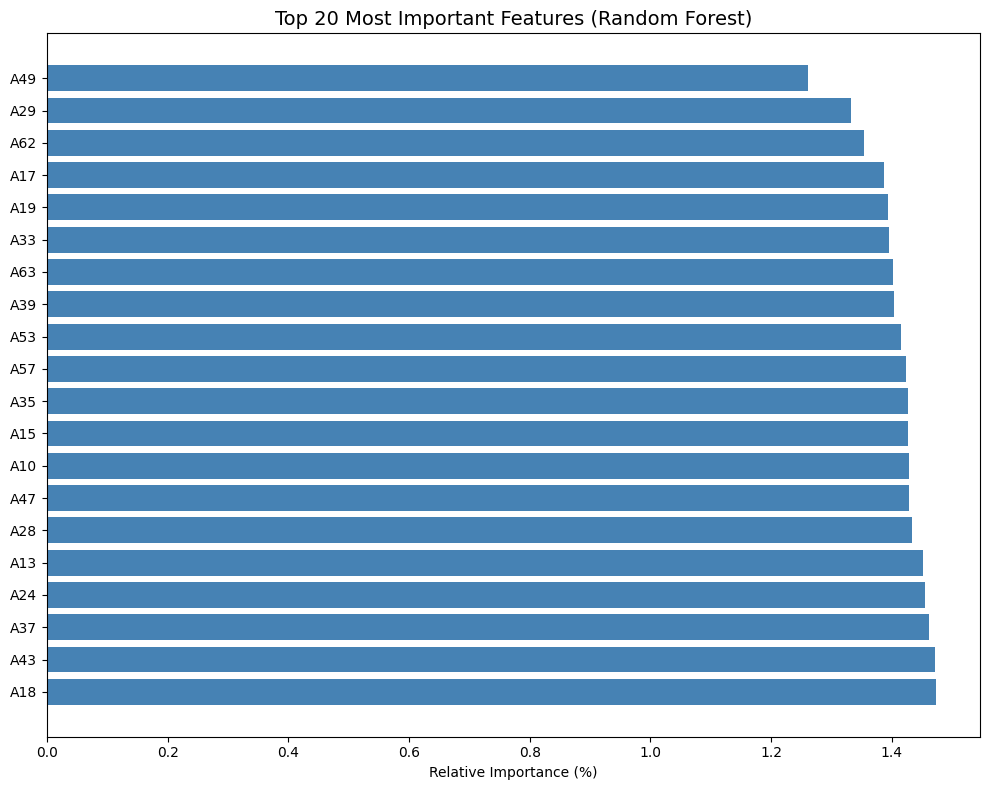

In [ ]:
#plot the feature importance using matplot lib
# Optional: Show only top 20 features
top_n = 20
df_plot = df_importance.tail(top_n)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(df_plot['Band'], df_plot['Relative Importance (%)'], color='steelblue')
plt.xlabel('Relative Importance (%)')
plt.title(f'Top {top_n} Most Important Features (Random Forest)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

**6. Export the result in Google Drive**

In [ ]:
export_task = ee.batch.Export.image.toDrive(
    image=lulc_map,
    description='RF_Classification_Result',
    folder='Earth Engine',
    fileNamePrefix='classification_rf',
    scale=10,
    region=aoi.geometry(),  # or aoi.geometry()
    maxPixels=1e13
)
export_task.start()
import time

while export_task.active():
    print('Exporting... (status: {})'.format(export_task.status()['state']))
    time.sleep(10)

print('Export complete (status: {})'.format(export_task.status()['state']))

Exporting... (status: READY)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting... (status: RUNNING)
Exporting.

**Implementation using Gradient Boosting Classifier**

In [11]:
param_grid = {
    'numberOfTrees': [100, 300, 500],
    'shrinkage': [0.005, 0.01, 0.1],
    'samplingRate': [0.7, 0.9],
    'seed': [0]
}
gbt_result = []

In [ ]:
# Grid search loop for Gradient Tree Boost
for n in param_grid['numberOfTrees']:
    for shrink in param_grid['shrinkage']:
        for samp in param_grid['samplingRate']:
                try:
                    gbt = ee.Classifier.smileGradientTreeBoost(
                        numberOfTrees=n,
                        shrinkage=shrink,
                        samplingRate=samp,
                        loss='LeastAbsoluteDeviation',
                        seed=0
                    ).train(
                        features=train_samples,
                        classProperty='LUCID',
                        inputProperties=finalimage.bandNames()
                    )

                    classified_test = test_samples.classify(gbt)
                    em = classified_test.errorMatrix('LUCID', 'classification')
                    acc = em.accuracy().getInfo()

                    gbt_result.append({
                        'numberOfTrees': n,
                        'shrinkage': shrink,
                        'samplingRate': samp,
                        'accuracy': acc
                    })

                except Exception as e:
                    print('Failed for params:', n, shrink, samp, e)

In [ ]:
gbt_df = pd.DataFrame(gbt_result)
best_gbt = gbt_df.sort_values('accuracy', ascending=False).iloc[0]
print("Best params:", best_gbt)

In [ ]:
# Train final classifier
best_clf = ee.Classifier.smileGradientTreeBoost(
    numberOfTrees=int(best_gbt['numberOfTrees']),
    shrinkage=float(best_gbt['shrinkage']),
    samplingRate=float(best_gbt['samplingRate']),
    maxNodes=best_gbt['maxNodes'],
    loss='LeastAbsoluteDeviation',
    seed=0
).train(
    features=train_samples,
    classProperty='LUCID',
    inputProperties=finalimage.bandNames()
)